In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 29 17:58:45 2016

@author: RENOUXTH
"""

import  os

#os.environ['PATH'] = os.environ['PATH'] + ';C:\\git-sdk-64\\mingw64\\bin'

#os.environ['PATH'] = os.environ['PATH'] + ';C:\\git-sdk-64\\xgboost\\lib'

import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import operator
import matplotlib.pyplot as plt

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    yhat[yhat<0]=0
    return np.nanmean(np.absolute(y-yhat))
    
#    np.minimum(np.absolute(y-yhat)/yhat, 1)
    
def rmspe_xg(yhat, y):
    y = y.get_label()
    #y = y.get_label()
    yhat = yhat
    #yhat = yhat
    return "rmspe", rmspe(y,yhat)
    
# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
     # Use some properties directly
    features.extend(data.columns)
    
    return data
    
## Start of main script

print("Load the training, test and store data using pandas")
##types = {'Annee' : np.dtype(int),
       ##  'Type_Offre': np.dtype(int),
       ##  'Code_Produit': np.dtype(int),
       ##  'Previ_Volume' : np.dtype(float),
       ##  'Nb_Jours': np.dtype(float),
       ##  'S_debut': np.dtype(float),
       ##  'UB': np.dtype(int),
       ##  'Taux_Degradation' : np.dtype(int),
       ##  'Magasin' : np.dtype(int),
       ##  'VMH': np.dtype(float),
       ##  'Baseline_Magasins' : np.dtype(float)}
        
##df = pd.read_csv('/Anaconda3/BDD Promo.csv', dtype=types, sep=';')
df = pd.read_csv('BDD Promo.csv', sep=';')

# Get rid of unnecessary features

#df = df.drop(['Jour', 'EAN_13', 'Libelle'], axis=1)

print("Use only Sales bigger then zero. Simplifies calculation of rmspe")
df = df[df["Ventes"] > 0]

#df['Ventes'] = np.log1p(df['Ventes'])

#df['Moyenne'] = df['Moyenne'] 
#df['Ventes_S-1'] = df['Ventes_S-1'] 
#df['Ventes_S-2'] = df['Ventes_S-2'] 
#df['Ventes_S-3'] = df['Ventes_S-3'] 
#df['Moyenne'] = np.log1p(df['Moyenne'])
#df['Ventes_S-1'] = np.log1p(df['Ventes_S-1'])
#df['Ventes_S-2'] = np.log1p(df['Ventes_S-2'])
#df['Ventes_S-3'] = np.log1p(df['Ventes_S-3'])
#df['Poids_des_Jours'] = np.log1p(df['Poids_des_Jours'])

# Preparing Train, Test and Validation sets

y = pd.DataFrame(df['Ventes'])

X = df.drop(['Ventes'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, \
random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, \
test_size = 0.15, random_state=38)

features = []

print("augment features")
build_features(features, X_train)
build_features([], X_test)
print(features)

print('training data processed')

params = {"objective": "reg:linear",
           "booster" : "gbtree",
           "eta": 0.03,
           "max_depth": 6,
           "subsample": 0.8,
           "colsample_bytree": 0.7,
           "silent": 1,
           "seed": 300,
           "lambda" : 0.3
           }
num_boost_round = 1000

#params = {"objective": "reg:linear",
#          "booster" : "gblinear",
#          "lambda" : 0.01
#          }
#num_boost_round = 30000

print("Train a XGBoost model")
#y_valid = np.log1p(y_valid)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=2000, verbose_eval=True)
  
# feval=rmspe_xg,
  
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(y_valid.Ventes.values, yhat)
#error = rmspe((y_valid), (yhat))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
dtest = xgb.DMatrix(X_test[features])
test_probs = gbm.predict(dtest)
error_test = rmspe(y_test.Ventes.values, test_probs)
#error_test = rmspe((y_test), (test_probs))
print('RMSPE: {:.6f}'.format(error_test))

print("Make predictions on the test set")
dtest = xgb.DMatrix(X_test[features])
test_probs = gbm.predict(dtest)
error_test = rmspe(y_test.Ventes.values, test_probs)
#error_test = rmspe((y_test), (test_probs))
print('RMSPE: {:.6f}'.format(error_test))




/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load the training, test and store data using pandas
Use only Sales bigger then zero. Simplifies calculation of rmspe
augment features
['Annee', 'Type_Offre', 'Code_Produit', 'Previ_Volume', 'Nb_Jours', 'S_debut', 'UB', 'Taux_Degradation', 'Magasin', 'VMH', 'Baseline_Magasin', 'Nb_Codes', 'Produit_Source']
training data processed
Train a XGBoost model
[0]	train-rmse:222.992	eval-rmse:226.421
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 2000 rounds.
[1]	train-rmse:218.548	eval-rmse:221.914
[2]	train-rmse:214.394	eval-rmse:217.726
[3]	train-rmse:210.381	eval-rmse:213.686
[4]	train-rmse:206.653	eval-rmse:209.943
[5]	train-rmse:202.933	eval-rmse:206.175
[6]	train-rmse:199.695	eval-rmse:202.878
[7]	train-rmse:196.29	eval-rmse:199.421
[8]	train-rmse:193.546	eval-rmse:196.7
[9]	train-rmse:190.256	eval-rmse:193.325
[10]	train-rmse:187.307	eval-rmse:190.299
[11]	train-rmse:184.211	eval-rmse:187.183
[12]	train-

[183]	train-rmse:93.0946	eval-rmse:95.9961
[184]	train-rmse:93.016	eval-rmse:95.9066
[185]	train-rmse:92.9741	eval-rmse:95.8649
[186]	train-rmse:92.8991	eval-rmse:95.7755
[187]	train-rmse:92.8354	eval-rmse:95.7309
[188]	train-rmse:92.8018	eval-rmse:95.7076
[189]	train-rmse:92.759	eval-rmse:95.6725
[190]	train-rmse:92.6327	eval-rmse:95.5766
[191]	train-rmse:92.5863	eval-rmse:95.5301
[192]	train-rmse:92.4888	eval-rmse:95.4454
[193]	train-rmse:92.4256	eval-rmse:95.3874
[194]	train-rmse:92.2901	eval-rmse:95.2866
[195]	train-rmse:92.2335	eval-rmse:95.2361
[196]	train-rmse:92.1113	eval-rmse:95.1462
[197]	train-rmse:92.0357	eval-rmse:95.0728
[198]	train-rmse:91.9721	eval-rmse:94.9963
[199]	train-rmse:91.9032	eval-rmse:94.9271
[200]	train-rmse:91.8023	eval-rmse:94.8476
[201]	train-rmse:91.7515	eval-rmse:94.8137
[202]	train-rmse:91.706	eval-rmse:94.769
[203]	train-rmse:91.6302	eval-rmse:94.6958
[204]	train-rmse:91.5594	eval-rmse:94.6279
[205]	train-rmse:91.5158	eval-rmse:94.5882
[206]	train-rms

[375]	train-rmse:84.9939	eval-rmse:89.6234
[376]	train-rmse:84.9818	eval-rmse:89.618
[377]	train-rmse:84.9586	eval-rmse:89.5927
[378]	train-rmse:84.9445	eval-rmse:89.5812
[379]	train-rmse:84.9082	eval-rmse:89.5353
[380]	train-rmse:84.8875	eval-rmse:89.5246
[381]	train-rmse:84.8603	eval-rmse:89.4997
[382]	train-rmse:84.8495	eval-rmse:89.4835
[383]	train-rmse:84.8127	eval-rmse:89.4701
[384]	train-rmse:84.8018	eval-rmse:89.4632
[385]	train-rmse:84.78	eval-rmse:89.4533
[386]	train-rmse:84.7703	eval-rmse:89.4451
[387]	train-rmse:84.723	eval-rmse:89.4071
[388]	train-rmse:84.7058	eval-rmse:89.3996
[389]	train-rmse:84.6915	eval-rmse:89.3908
[390]	train-rmse:84.6621	eval-rmse:89.3691
[391]	train-rmse:84.6361	eval-rmse:89.3689
[392]	train-rmse:84.6097	eval-rmse:89.3593
[393]	train-rmse:84.5927	eval-rmse:89.3427
[394]	train-rmse:84.5806	eval-rmse:89.3381
[395]	train-rmse:84.5494	eval-rmse:89.3142
[396]	train-rmse:84.537	eval-rmse:89.3018
[397]	train-rmse:84.5202	eval-rmse:89.2918
[398]	train-rmse

[567]	train-rmse:80.7966	eval-rmse:87.132
[568]	train-rmse:80.7813	eval-rmse:87.1186
[569]	train-rmse:80.7515	eval-rmse:87.095
[570]	train-rmse:80.716	eval-rmse:87.0762
[571]	train-rmse:80.6915	eval-rmse:87.0638
[572]	train-rmse:80.6753	eval-rmse:87.0545
[573]	train-rmse:80.6653	eval-rmse:87.0581
[574]	train-rmse:80.6329	eval-rmse:87.0345
[575]	train-rmse:80.6297	eval-rmse:87.0313
[576]	train-rmse:80.6204	eval-rmse:87.0249
[577]	train-rmse:80.607	eval-rmse:87.0132
[578]	train-rmse:80.5999	eval-rmse:87.0091
[579]	train-rmse:80.5934	eval-rmse:87.0066
[580]	train-rmse:80.5816	eval-rmse:87.0009
[581]	train-rmse:80.5714	eval-rmse:86.9908
[582]	train-rmse:80.5629	eval-rmse:86.9851
[583]	train-rmse:80.5526	eval-rmse:86.9741
[584]	train-rmse:80.5262	eval-rmse:86.9532
[585]	train-rmse:80.5129	eval-rmse:86.9436
[586]	train-rmse:80.4899	eval-rmse:86.9318
[587]	train-rmse:80.4621	eval-rmse:86.8991
[588]	train-rmse:80.4249	eval-rmse:86.8806
[589]	train-rmse:80.4058	eval-rmse:86.8598
[590]	train-rms

[759]	train-rmse:77.8326	eval-rmse:85.4936
[760]	train-rmse:77.8274	eval-rmse:85.4922
[761]	train-rmse:77.8135	eval-rmse:85.4865
[762]	train-rmse:77.8089	eval-rmse:85.4838
[763]	train-rmse:77.7839	eval-rmse:85.4354
[764]	train-rmse:77.7661	eval-rmse:85.4279
[765]	train-rmse:77.757	eval-rmse:85.4213
[766]	train-rmse:77.7503	eval-rmse:85.4265
[767]	train-rmse:77.7461	eval-rmse:85.4229
[768]	train-rmse:77.7426	eval-rmse:85.4226
[769]	train-rmse:77.7331	eval-rmse:85.4182
[770]	train-rmse:77.7199	eval-rmse:85.4102
[771]	train-rmse:77.7147	eval-rmse:85.4073
[772]	train-rmse:77.7093	eval-rmse:85.4024
[773]	train-rmse:77.6974	eval-rmse:85.393
[774]	train-rmse:77.6706	eval-rmse:85.3821
[775]	train-rmse:77.6632	eval-rmse:85.3825
[776]	train-rmse:77.6437	eval-rmse:85.3646
[777]	train-rmse:77.6128	eval-rmse:85.3443
[778]	train-rmse:77.6074	eval-rmse:85.3405
[779]	train-rmse:77.5971	eval-rmse:85.3377
[780]	train-rmse:77.5713	eval-rmse:85.3396
[781]	train-rmse:77.5651	eval-rmse:85.3355
[782]	train-r

[951]	train-rmse:75.3485	eval-rmse:84.2786
[952]	train-rmse:75.3368	eval-rmse:84.2734
[953]	train-rmse:75.3274	eval-rmse:84.2708
[954]	train-rmse:75.3204	eval-rmse:84.2689
[955]	train-rmse:75.3132	eval-rmse:84.2599
[956]	train-rmse:75.2888	eval-rmse:84.2423
[957]	train-rmse:75.2755	eval-rmse:84.2314
[958]	train-rmse:75.2689	eval-rmse:84.2241
[959]	train-rmse:75.266	eval-rmse:84.2267
[960]	train-rmse:75.259	eval-rmse:84.2325
[961]	train-rmse:75.2493	eval-rmse:84.2284
[962]	train-rmse:75.2403	eval-rmse:84.2254
[963]	train-rmse:75.2335	eval-rmse:84.2239
[964]	train-rmse:75.224	eval-rmse:84.2145
[965]	train-rmse:75.2114	eval-rmse:84.2077
[966]	train-rmse:75.2065	eval-rmse:84.204
[967]	train-rmse:75.2015	eval-rmse:84.2018
[968]	train-rmse:75.1868	eval-rmse:84.1936
[969]	train-rmse:75.173	eval-rmse:84.1829
[970]	train-rmse:75.1654	eval-rmse:84.1817
[971]	train-rmse:75.1613	eval-rmse:84.1833
[972]	train-rmse:75.1458	eval-rmse:84.1725
[973]	train-rmse:75.1295	eval-rmse:84.1661
[974]	train-rmse

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:161: RuntimeWarning: overflow encountered in expm1


ImportError: No module named openpyxl

Make actual predictions


/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in expm1


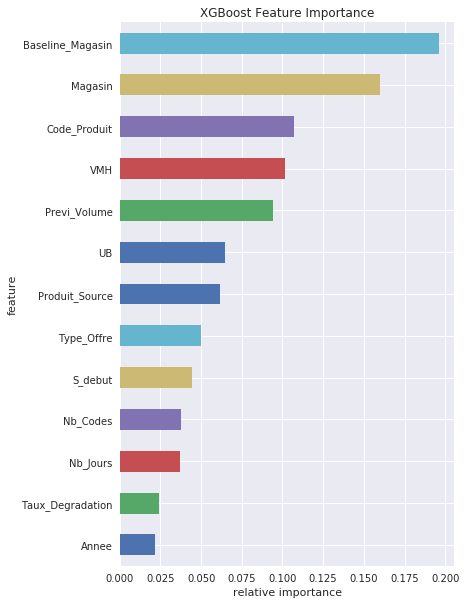

In [13]:
F = pd.read_csv('Forecast.csv', sep=';')

print("Make actual predictions")
dforecast = xgb.DMatrix(F[features])
forecast_probs = gbm.predict(dforecast)

# Export results
result = pd.DataFrame({'Code_Produit': X_test['Code_Produit'], 'Nb_Jours': \
X_test['Nb_Jours'], 'Type_Offre': X_test['Type_Offre'], \
'Taux_Degradation' : X_test['Taux_Degradation'], 'Ventes': np.expm1(test_probs)})
true_result = pd.DataFrame({'Code_Produit': X_test['Code_Produit'], \
'Nb_Jours': X_test['Nb_Jours'], 'Type_Offre' : X_test['Type_Offre'], \
'Taux_Degradation' : X_test['Taux_Degradation'], 'Ventes': y_test['Ventes']})
forecast = pd.DataFrame({'Code_Produit': F['Code_Produit'], \
'Semaine_debut': F['S_debut'], 'Ventes': forecast_probs,'Magasin': F['Magasin'] })

true_result.to_csv("xgboost_11_Promo_submission.csv", index=False)
forecast.to_csv("xgboost_12_Promo_submission.csv", index=False)

# XGB feature importances
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df2 = pd.DataFrame(importance, columns=['feature', 'fscore'])
df2['fscore'] = df2['fscore'] / df2['fscore'].sum()

featp = df2.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)


pd.show_versions()

In [6]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 2.7.15.final.0
python-bits: 64
OS: Linux
OS-release: 4.14.41+
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.22.0
pytest: None
pip: 18.0
setuptools: 40.0.0
Cython: None
numpy: 1.14.0
scipy: 1.0.0
pyarrow: None
xarray: None
IPython: 5.8.0
sphinx: None
patsy: 0.5.0
dateutil: 2.5.0
pytz: 2016.7
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.1.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml: None
bs4: 4.6.3
html5lib: 1.0.1
sqlalchemy: 1.2.10
pymysql: None
psycopg2: None
jinja2: 2.8
s3fs: None
fastparquet: None
pandas_gbq: 0.3.0
pandas_datareader: None


In [8]:
%%bash
pip install xlrd

In [9]:
%%bash
pip install xlsxwriter